## Adamopoulos and Restuccia AER 2014  (port from MATLAB)

Our first Ipython effort. Matt Baker did most of the heavy lifting of porting the A&R model from MATLAB. 
Their MATLAB code was not very readable (and at times downright cryptic) nor very efficient so we've cleaned things up a bit along the way.

In [3]:
%pylab inline     
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


The model starts with a description as to how the  works. 

But first output in the non-agricultural sector is modeled this way:

Production is Cobb-Douglas: $Y_n=AK_n^\alpha N_n^{1-\alpha}$

This implies that we have simple expressions for the economy-wide wage $w$ and rental rate on capital $r$:

$r=MPK=\alpha A K^\alpha_n N^{1-\alpha}_n$

which becomes:

$r=\alpha A \left(\frac{K_n}{N_n}\right)^{\alpha-1}$

while we also have:

$w=MPL=(1-\alpha) A \left(\frac{K_n}{N_n}\right)^{1-\alpha}$

The next part of the model is the agricultural sector. Here, we have heterogeneity in farm managers characterized by a "skill" variable $s$. The farm production function is:

$y_a=A\kappa \left[\theta k^\rho+(1-\theta)(sl)^\rho \right]^\frac{\gamma}{\rho}$

As Jonathan notes, this is a little different than Lucas's (1978) span of control, as $s$ here is augmenting $l$ - land - not overall production. That is, $s$ is not outside the brackets.

Before getting into solution, we can start the process of coding things up in Julia. Some simple aspects of the calibration involve normalization of $\kappa$ and $A$ at unity. We also have values of $\alpha$ and $\gamma$ set from outside sources:

In [4]:
KAPPA_US=1
A_US=1
ALPHA=0.33
GAMMA=0.54

Some additional information that is required are distribution of the size of farms.  This information comes in two pieces. First, there is the fraction of each farm in each size class. Then, there is the distribution of land by size class. These two pieces of information are as follows (duly noting that I'm not exactly sure how these interact in the model at this point):

In [5]:
farm_pdf_data=[.1056, .2813, .0698, .0871, .0794, .0633, .0397, .0310, .0964, .0679, .0420, .0365]

As alluded to above, the actual size of the bins are as follows:

In [6]:
land_pdf_data=[.0012, .0173, .0097, .0171, .0220, .0238, .0187, .0176, .0823, .01129, .01384, .05389 ]

Some additional calibrated variables include: 
The average farm size (in the United States), 
The share of labor in agriculture in the United States, 
The United States capital labor ratio,
The ratio of capital land ratio between smallest and largest farms,
The ratio of agricultural to non-agricultural labor productivity, 
The long-run share of labor in agriculture, 
And the agricultural land income share. 

Respectively, these variables are:

In [7]:
AFS_US=169.249
Na_US=.025
KY_US=2.5
kl_min_max_data=84.85
paYNan_ratio=1.0/2.0
PHI=0.010
L_inc_sh=0.18

The calibrated variables are then used to determine many of the quantities that are actually used in modeling. For one, we have the mysterious quantity:

In [8]:
rKa_qL_US=GAMMA/L_inc_sh-1

Jonathan has pointed out that this is funny little equation results from Euler's Theorem: total factor payments add up to $\gamma$ of output, with profits being what is left after this. Accordingly:

$rK+qL=\gamma F_KK+\gamma F_LN=\gamma Y_a$

This implies:

$\frac{rK}{qL}+1=\frac{\gamma Y_a}{qL}$.

We then have the above rKa_ql_US as the term $\frac{rK}{qL}$ in the previous equation:

$\frac{rK}{qL}=\frac{\gamma Y_a}{qL}-1$.


A next equation that is a little fishy is the following "derived calibration":

In [9]:
YN_US=(A_US**(1/(1-ALPHA)))*KY_US**(ALPHA/(1-ALPHA))

In terms of nice formatting, I'm thinking this is worker productivity. That is, we have: 

$\frac{Y_n}{N_n}=A^{\frac{1}{1-\alpha}}\left(\frac{K_n}{Y_n}\right)^\frac{\alpha}{1-\alpha}$

The last expression is aggregate labor productivity, but it is hard to see where an expression like this could come from. But first, let's think about the goal, which is to write labor productivity as a function of the capital-output ratio. If we started with a function like:

$Y_n=AK_n^\alpha N_n^{1-\alpha}$

Now "solve" this for $N_n$ and write this as:

$Y_n^{\frac{1}{1-\alpha}}=A^{\frac{1}{1-\alpha}}N_nK_n^{\frac{\alpha}{1-\alpha}}$

Now, we note that we can write this as follows:

$Y_nY_n^\frac{\alpha}{1-\alpha}=A^\frac{1}{1-\alpha}N_nK_n^\frac{\alpha}{1-\alpha}$

Now divide through by $Y_n^\frac{\alpha}{1-\alpha}N_n$ to get the desired result.

The few quantities of interest are calibrated as follows:

In [10]:
K_US=KY_US*YN_US
LN_US=AFS_US*Na_US
one_minus_XI=(1-GAMMA)/(1-ALPHA)*paYNan_ratio
XI=1-one_minus_XI

In [11]:
one_minus_XI

0.34328358208955223

What is this variable $\xi$? It is called the "value productivity ratio" in the paper. The operative assumption is that working in nonagriculture is subject to a tax. So non-agricultural worker $w(1-\xi)$. 

It is a little hard for me to see why this is needed or where it is coming from at the moment. Anyways, we start out with a grid of guesses for $\mu$ and $\sigma$, and also provide some other details of the search for the mean and variance:

In [12]:
import numpy as np
mean=np.linspace(-1.836,-1.8,20)
var=np.linspace(4.6553,4.75,20)
DIFF=1000
C=np.zeros((12,1))
MU_min=0.0
SIGMA_min=0.0

MU=mean[1]
SIGMA=var[1]

Actually, the above entries should be looped over, but aren't in the code, which is presumably operating from the optimum values of $\mu$ and $\sigma$. Now, we make a grid of points and approximate a log-normal. First, we need a couple of functions that create a discretized log-normal distribution. While there are probably better ways to do this than following exactly what R/A did,let's in fact just follow along. First, let's get the package we need:

In [13]:
from scipy.integrate import quad 
import math

We now build two functions. The first gives a log-normal pdf, while the second gives an approximate value for the cdf at the given point. Not how it might be beneficial to bring in stuff like "log" right off the bat, rather than having to use the "np" handle every time. Also note how ^ (squared) is instead **. 

In [14]:
def lognorm_pdf(x,m,v):
    s=np.sqrt(v)
    out1=np.divide(1.,np.multiply(x,s*np.sqrt(2.*math.pi)))
    out2=np.exp(np.divide((-(np.log(x)-m)**2),(2*v)))
    return out1*out2

The above might be viewed as a more efficient coding of the lognormal pdf than R/A use. We also need a function that gives an approximation to the integrated lognormal:

In [15]:
def lognorm_discrete(x1,x2,m,v):
    out=quad(lognorm_pdf,x1,x2,(m,v))
    return out

Now, we make a little loop that approximates the log normal we programmed above

In [16]:
s_n=6000
s_grid=np.logspace(-5.5,2.,s_n)
s_prob=np.zeros((s_n,1))
VAR_s=SIGMA**2

We do have to endulge a few shenanigans here, mainly because s_grid above is not really a matrix as we would like it to be, but really just an array filled full of a list of numbers. Accordingly, let's convert it into the same form as the variables we are deriving from it:

In [17]:
s_grid=np.asmatrix(s_grid)
s_grid=s_grid.T
np.shape(s_grid)

(6000L, 1L)

In [18]:
s_grid[0]

matrix([[  3.16227766e-06]])

Now, we loop over the above and "fill in" the probability grid so that we have a whole probability distribution:


In [19]:
for i in range(0,s_n-1):
    if i==0:
        d=(s_grid[1]-s_grid[0])/2
        s_prob[i]=lognorm_discrete(s_grid[i]-d,s_grid[i]+d,MU,VAR_s)[0]
    else:
        d=(s_grid[i]-s_grid[i-1])/2
        s_prob[i]=lognorm_discrete(s_grid[i]-d,s_grid[i]+d,MU,VAR_s)[0]

Let's see what this looks like once we have approximated it. First, we import the plot library, and then just plot the numbers:

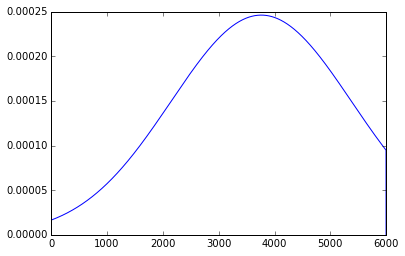

In [20]:
import matplotlib.pyplot as plt
plt.plot(s_prob)
plt.show()

I can't see where I've made a mistake, so perhaps that is correct, even though it looks a little goofy. Continuing on, we now get the sum of all the probabilities and see if they sum to unity:

In [21]:
np.sum(s_prob)

0.90506654100125528

Thus, we have to renormalize, even though this is starting to seem a little sketchy...

**JC:** XX in the MATLAB code is 0.90539 so ever so slightly off..

In [22]:
XX=sum(s_prob)
if XX<1:
    s_prob=s_prob+(1-XX)/s_n

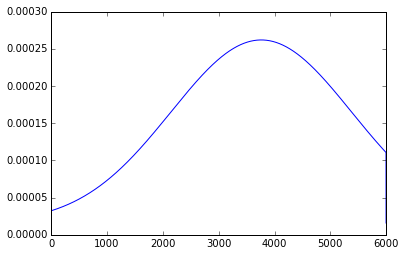

In [23]:
plt.plot(s_prob)
plt.show()

Because I find it perplexing that there is such a large truncation region of the graph, let's see if we can replicate the results with actual functions. 

In [24]:
import scipy.stats as sps

Now, in Python, the log-normal is denoted a bit differently than R/A denote it. The python function uses parameters sc, sh, and lo together as follows:

$f(x|sh,lo,sc)=\frac{1}{(x-lo)sh\sqrt{2\pi}}e^{\frac{-(\ln(x-lo)-ln(sc))^2}{2sh^2}}$

So, if the Python function is to correspond with R/A's function, we need $lo=0$. Moreover, since $\mu=ln(sc)$, we need $sc=e^\mu$. Finally, R/A parameterize the variance, where $v=sh^2$. Therefore, we need $sh=\sqrt{v}$. To check this out:

In [25]:
print sps.lognorm.pdf(2,np.sqrt(2),0,np.exp(1))
print lognorm_pdf(2,1,2)
print sps.lognorm.cdf(2,np.sqrt(2),0,np.exp(1))

0.13776596115
0.13776596115
0.414112858205


We can also use the lognorm CDF function to perhaps do a bit better than R/A, or at least check their work. We want the mass between the "slices," so:

In [26]:
s_prob2=np.zeros((s_n,1))
for i in range(0,s_n-1):
    if i==0:
        d=(s_grid[1]-s_grid[0])/2
        s_prob2[i]=sps.lognorm.cdf(s_grid[i]+d,np.sqrt(VAR_s),0,np.exp(MU))-sps.lognorm.cdf(s_grid[i]-d,np.sqrt(VAR_s),0,np.exp(MU))
    else:
        d=(s_grid[i]-s_grid[i-1])/2
        s_prob2[i]=sps.lognorm.cdf(s_grid[i]+d,np.sqrt(VAR_s),0,np.exp(MU))-sps.lognorm.cdf(s_grid[i]-d,np.sqrt(VAR_s),0,np.exp(MU))


While we are at it... let's try something even simpler

In [27]:
np.exp(MU)

0.1597563777573214

In [28]:
s_prob3=np.zeros((s_n,1))
d = s_grid[1:]-s_grid[:-1]
C_top = sps.lognorm.cdf(s_grid[1:],np.sqrt(VAR_s),0,np.exp(MU))
C_low = sps.lognorm.cdf(s_grid[:-1],np.sqrt(VAR_s),0,np.exp(MU))
s_prob3 = C_top - C_low
s_prob3 =  np.append(s_prob2[0],s_prob3)


In [29]:
len(s_prob3)
s_prob3

array([  1.65805164e-05,   1.65685468e-05,   1.65923419e-05, ...,
         9.50706677e-05,   9.49896307e-05,   9.49086266e-05])

In [30]:
s_prob2[0],s_prob2[1],s_prob2[2],s_prob3[0],s_prob3[1]

(array([  1.65805164e-05]),
 array([  1.65566015e-05]),
 array([  1.65803762e-05]),
 1.6580516426216441e-05,
 1.6568546826193492e-05)

In [59]:
type(s_prob3)

numpy.ndarray

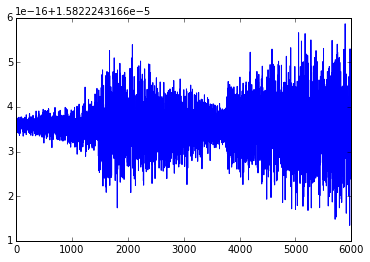

In [31]:
difference=abs(s_prob-s_prob2)
plt.plot(difference)
plt.show()

In [32]:
difference=abs(s_prob2-s_prob3)
#plt.plot(difference)
#plt.show()
difference.max()

0.00024643122452328026

So they are very close, a couple of thousandths off. It is also encouraging to know we got the programming correct.  Let's now try to code in the calibration_eval function that R/A use. We also need some guesses for other stuff, such as $\rho$

In [33]:
RHO=.24

Because one has to be very careful with certain types of objects (particularly matrices), I'm going to break up the calibration_eval function a little bit more than R/A do. 

In [34]:
def calibration_eval(x,rKa_qL_US,Na_US):    
    
    KNn_US=x[0]                             # non-ag capital-labor
    THETA=x[1]                              # parameter in Ag production       
    pa_US=x[2]                              # relative price of agricultural goods
    
    w_US=(1-ALPHA)*A_US*KNn_US**ALPHA       # w = MPLNa     
    r_US=ALPHA*A_US*KNn_US**(ALPHA-1)
    Ka_US=K_US-(KNn_US*(1-Na_US))
    KNa_US=Ka_US/Na_US
    YNn_US=A_US*(KNn_US**ALPHA)                                                        #not used?                  
    q_r_US=(rKa_qL_US**(-1))*Ka_US/LN_US
    q_US=q_r_US*r_US
    aBAR=(1/(pa_US*(1-PHI)))*((w_US*(1-XI)*Na_US/((1-GAMMA)))-PHI*(w_US*(1-XI)+q_US*LN_US+r_US*K_US))  #not used?
    psi_s_vec1=THETA*((THETA*q_r_US/(1-THETA))**(RHO/(1-RHO)))*np.ones((s_n,1))
    psi_s_vec2=(1-THETA)*np.power(s_grid,(RHO/(1-RHO)))
    psi_s_vec=psi_s_vec1+psi_s_vec2
    l_vec1=((pa_US*GAMMA*(1-THETA)*KAPPA_US*A_US/q_US)**(1/(1-GAMMA)))
    l_vec2=(np.power(psi_s_vec,((GAMMA-RHO)/(RHO*(1-GAMMA)))))
    l_vec3=(np.power(s_grid,(RHO/(1-RHO))))
    l_vec=l_vec1*np.multiply(l_vec2,l_vec3)
    k_l_vec=((THETA*q_r_US/(1-THETA))**(1/(1-RHO)))*((np.power(s_grid,(-RHO/(1-RHO)))))
    k_vec = np.multiply(k_l_vec , l_vec)
    ya_vec=KAPPA_US*A_US*np.power((THETA*np.power(k_vec,RHO)+(1-THETA)*np.power(np.multiply(s_grid,l_vec),RHO)),GAMMA/RHO)
    PI_vec=(1-GAMMA)*pa_US*ya_vec
    f1=(1-XI)*w_US-np.sum(np.multiply(s_prob,PI_vec))
    f2=KNa_US - np.sum(np.multiply(s_prob,k_vec))
    f3=LN_US - Na_US*(np.sum(np.multiply(s_prob,l_vec)))
    f=f1,f2,f3
    g=np.dot(f,f)
    return g

**JC:**  As of 1/21 it is reproducing the matlab evaluation call exactly.

In [35]:
guess = array([3.2,0.9,0.4])
calibration_eval(guess,rKa_qL_US,Na_US)

949.4260053043738

**JC:** MATLAB calibration_eval gives (when  RHO=0.24):

>> calibration_eval(guess,rKa_qL_US,Na_US)

ans =

      0.26683       39.719       4.1983
     

In [36]:
import scipy.optimize as so

In [37]:
x0=np.array([3.2,.84,.27])
a=rKa_qL_US,Na_US
result=so.minimize(calibration_eval,x0,args=a,method='Nelder-Mead')

-c:15: RuntimeWarning: invalid value encountered in double_scalars
-c:18: RuntimeWarning: invalid value encountered in double_scalars
-c:19: RuntimeWarning: invalid value encountered in power
-c:22: RuntimeWarning: invalid value encountered in double_scalars
-c:24: RuntimeWarning: invalid value encountered in power


In [38]:
result

  status: 0
    nfev: 210
 success: True
     fun: 5.8793619412223842e-08
       x: array([ 3.97104018,  0.8886881 ,  0.31545382])
 message: 'Optimization terminated successfully.'
     nit: 118

It seems then that we are able to reproduce results as obtained by A/R. The next thing we might like to do is see how the rest of the project goes. What we are now going to do is try to get a function that does what the rest of the calibration exercise does, but have this actually be a function, and not just an external loop. So, in essence, the function should work as follows:

1. Arguments taken in by the function should be $\rho, \mu, $ and $\sigma$.
2. The first order of business is then simulating a $\mu$, $\sigma$ log-normal distribution as done in the paper.
3. I don't see any reason why rKa_qL_US and Na_US should be afforded special status as arguments. Can't they be globals as well?
4. Given a simulated distribution, and the fixed values of rKa_qL_US and Na_US, the next thing to be done is to solve for the x-vector given these values (using a nested optimization routine, as above)
5. Given the results, we then run the rest of A/R's code and "match moments." 

Before getting started, we will first define bins ahead of time, exploiting Python's nice way of working with scope. I am also going to try and improve the code a bit where I think it needs it. Here are the bins: 

In [39]:
bins=3.64,19.82,27.92,40.06,56.25,72.44,88.63,104.81,201.94,404.28,808.97
np.shape(bins)

(11L,)

In [40]:
bins

(3.64,
 19.82,
 27.92,
 40.06,
 56.25,
 72.44,
 88.63,
 104.81,
 201.94,
 404.28,
 808.97)

In [41]:
np.max(s_prob)

0.00026189928029478283

In [42]:
checker=1,2,4,5,6,7,98,100,1257,2000

In [43]:
np.searchsorted(checker,7,'rightsided')

6

In [44]:
def globalCalibrator(x):
    MU=x[0]
    SIGMA=x[1]
    RHO=x[2]
    VAR_s=SIGMA**2
    s_prob=np.zeros((s_n,1))                                                # Redefine this every time
    for i in range(0,s_n):
        if i==0:
            d=(s_grid[1]-s_grid[0])/2
            s_prob[i]=lognorm_discrete(s_grid[i]-d,s_grid[i]+d,MU,VAR_s)[0]
        else:
            d=(s_grid[i]-s_grid[i-1])/2
            s_prob[i]=lognorm_discrete(s_grid[i]-d,s_grid[i]+d,MU,VAR_s)[0] 
    XX=sum(s_prob)
    if XX<1:
        s_prob=s_prob+(1-XX)/s_n  
    Xresult=so.minimize(calibration_eval,x0,args=a,method='Nelder-Mead')   #Sloppy - relying on global definitions being just what want them to be
    KNn_US=Xresult.x[0]
    THETA=Xresult.x[1]
    pa_US=Xresult.x[2]
    w_US=(1-ALPHA)*A_US*KNn_US**ALPHA           # I'm not sure any of this is necessary given how Python's local/global definitions are so fluid
    r_US=ALPHA*A_US*KNn_US**(ALPHA-1)
    Ka_US=K_US-(KNn_US*(1-Na_US))
    KNa_US=Ka_US/Na_US
    YNn_US=A_US*(KNn_US**ALPHA)                                                                          
    q_r_US=(rKa_qL_US**(-1))*Ka_US/LN_US
    q_US=q_r_US*r_US
    aBAR=(1/(pa_US*(1-PHI)))*((w_US*(1-XI)*Na_US/((1-GAMMA)))-PHI*(w_US*(1-XI)+q_US*LN_US+r_US*K_US))  
    psi_s_vec1=THETA*((THETA*q_r_US/(1-THETA))**(RHO/(1-RHO)))*np.ones((s_n,1))
    psi_s_vec2=(1-THETA)*np.power(s_grid,(RHO/(1-RHO)))
    psi_s_vec=psi_s_vec1+psi_s_vec2
    l_vec1=((pa_US*GAMMA*(1-THETA)*KAPPA_US*A_US/q_US)**(1/(1-GAMMA)))
    l_vec2=(np.power(psi_s_vec,((GAMMA-RHO)/(RHO*(1-GAMMA)))))
    l_vec3=(np.power(s_grid,(RHO/(1-RHO))))
    l_vec=l_vec1*np.multiply(l_vec2,l_vec3)
    k_l_vec=((THETA*q_r_US/(1-THETA))**(1/(1-RHO)))*((np.power(s_grid,(-RHO/(1-RHO)))))
    k_vec = np.multiply(k_l_vec , l_vec)
    ya_vec=KAPPA_US*A_US*np.power((THETA*np.power(k_vec,RHO)+(1-THETA)*np.power(np.multiply(s_grid,l_vec),RHO)),GAMMA/RHO)
    PI_vec=(1-GAMMA)*pa_US*ya_vec
    l_value = sum(np.multiply(s_prob,l_vec))           # Average farm size
    YNa_value = sum(np.multiply(s_prob,ya_vec))        # Agricultural Labor Productivity
    YN_value = Na_US*pa_US*YNa_value+(1-Na_US)*YNn_US  # Aggregate Labor Productivity
    binIndices=np.zeros((12,1))
    farms=np.zeros((12,1))
    lands=np.zeros((12,1))
    Capital=np.zeros((12,1))
    Output=np.zeros((12,1))
    ss=np.zeros((12,1))
    startIndex=0
    l_vec=np.array(l_vec)
    for i in range(0,11):
        binIndices[i]=(np.searchsorted(l_vec[:,0],bins[i],'rightsided'))
        indexToUse=int(binIndices[i])
        farms[i]=np.sum(s_prob[startIndex:indexToUse])
        lands[i]=np.sum(np.multiply(l_vec[startIndex:indexToUse],s_prob[startIndex:indexToUse]))/l_value
        Capital[i]=np.sum(np.multiply(k_vec[startIndex:indexToUse],s_prob[startIndex:indexToUse]))
        Output[i]=np.sum(np.multiply(ya_vec[startIndex:indexToUse],s_prob[startIndex:indexToUse]))
        ss[i]=np.sum(np.multiply(s_grid[startIndex:indexToUse],s_prob[startIndex:indexToUse]))
        startIndex=indexToUse+1
    farms[11]=np.sum(s_prob[startIndex:s_n])
    lands[11]=np.sum(np.multiply(l_vec[startIndex:s_n],s_prob[startIndex:s_n]))
    Capital[11]=np.sum(np.multiply(k_vec[startIndex:s_n],s_prob[startIndex:s_n]))
    Output[11]=np.sum(np.multiply(ya_vec[startIndex:s_n],s_prob[startIndex:s_n]))
    ss[11]=np.sum(np.multiply(s_grid[startIndex:s_n],s_prob[startIndex:s_n]))
    kl_min_max_model=Capital[0]/(lands[0]*l_value)/(Capital[11]/(lands[11]*l_value))
    farmdata=np.asmatrix(farm_pdf_data).T
    diff1=farms-farmdata
    diff2=np.asmatrix((kl_min_max_model-kl_min_max_data)/kl_min_max_data)
    diff=np.vstack((diff1,diff2))
    print diff.T
    val=np.dot(diff1.T,diff1)
    print MU,SIGMA,RHO,val
    return val


In [45]:
xGuess=-5,1.9,.25
xGuess =-2.7889030987, 1.69147901341, 0.502734963506
optResult=so.minimize(globalCalibrator,xGuess,method='Nelder-Mead',tol=1e-3)

[[ -2.67480427e-03   3.84390340e-03   6.76023481e-03  -5.19314851e-03
   -5.32757878e-03  -1.10751810e-02  -1.06718861e-03  -7.12350429e-04
    3.73819514e-03   3.66626832e-03  -1.80007770e-04   2.73850591e-03
    2.29730701e+03]]
-2.7889030987 1.69147901341 0.502734963506 [[ 0.00028224]]
[[  1.28039788e-02   2.02097517e-02   7.66724328e-03  -5.59007806e-03
   -6.88791732e-03  -1.28769938e-02  -2.79074878e-03  -2.30828490e-03
   -3.22831841e-03  -3.27133730e-03  -5.35342055e-03  -3.71165991e-03
    1.98646181e+03]]
-2.92834825364 1.69147901341 0.502734963506 [[ 0.00095235]]
[[  8.51199004e-03  -2.15877141e-03   3.24167164e-03  -9.07794597e-03
   -8.68851772e-03  -1.32134975e-02  -2.45211047e-03  -1.64030628e-03
    2.15940732e-03   4.99623475e-03   2.64350357e-03   1.03397908e-02
    3.09420168e+03]]
-2.7889030987 1.77605296408 0.502734963506 [[ 0.00057235]]
[[  1.74356401e-02  -1.04329818e-02   2.06763283e-04  -1.26062494e-02
   -1.02222042e-02  -1.41478541e-02  -2.58867361e-03  -2.04

In [46]:
optResult

  status: 0
    nfev: 63
 success: True
     fun: 0.00027174323130965163
       x: array([-2.79013625,  1.68176697,  0.50379805])
 message: 'Optimization terminated successfully.'
     nit: 31

In [47]:
MUHat=optResult.x[0]
SIGMAHat=optResult.x[1]
RHOHat=optResult.x[2]
RHOHat,MUHat,SIGMAHat

(0.50379805395728861, -2.7901362478963154, 1.6817669666255064)

In [48]:
s_probHat=np.zeros((s_n,1))
for i in range(0,s_n-1):
    if i==0:
        d=(s_grid[1]-s_grid[0])/2
        s_probHat[i]=lognorm_discrete(s_grid[i]-d,s_grid[i]+d,MUHat,SIGMAHat)[0]
    else:
        d=(s_grid[i]-s_grid[i-1])/2
        s_probHat[i]=lognorm_discrete(s_grid[i]-d,s_grid[i]+d,MUHat,SIGMAHat)[0]

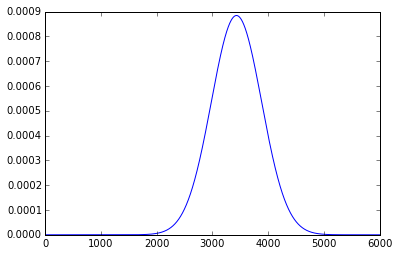

In [49]:
plt.plot(s_probHat)
plt.show()

In [50]:
XX=sum(s_probHat)
if XX<1:
    s_probHat=s_probHat+(1-XX)/s_n

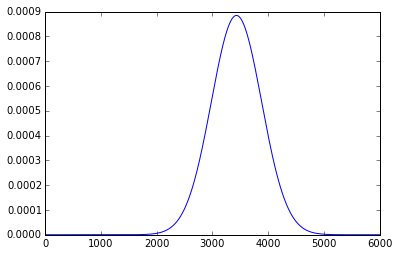

0.998562706272


In [51]:
plt.plot(s_probHat)
plt.show()
print XX

It seems like a good idea to make a little code that can generate quantities of interest based on this. So, here goes:

In [52]:
    VAR_sHAT=SIGMA**2
    XresultHat=so.minimize(calibration_eval,x0,args=a,method='Nelder-Mead')   #Sloppy - relying on global definitions being just what want them to be
    KNn_US=XresultHat.x[0]
    THETA=XresultHat.x[1]
    pa_US=XresultHat.x[2]
    w_US=(1-ALPHA)*A_US*KNn_US**ALPHA           # I'm not sure any of this is necessary given how Python's local/global definitions are so fluid
    r_US=ALPHA*A_US*KNn_US**(ALPHA-1)
    Ka_US=K_US-(KNn_US*(1-Na_US))
    KNa_US=Ka_US/Na_US
    YNn_US=A_US*(KNn_US**ALPHA)                                                                          
    q_r_US=(rKa_qL_US**(-1))*Ka_US/LN_US
    q_US=q_r_US*r_US
    aBAR=(1/(pa_US*(1-PHI)))*((w_US*(1-XI)*Na_US/((1-GAMMA)))-PHI*(w_US*(1-XI)+q_US*LN_US+r_US*K_US))  
    psi_s_vec1=THETA*((THETA*q_r_US/(1-THETA))**(RHO/(1-RHO)))*np.ones((s_n,1))
    psi_s_vec2=(1-THETA)*np.power(s_grid,(RHO/(1-RHO)))
    psi_s_vec=psi_s_vec1+psi_s_vec2
    l_vec1=((pa_US*GAMMA*(1-THETA)*KAPPA_US*A_US/q_US)**(1/(1-GAMMA)))
    l_vec2=(np.power(psi_s_vec,((GAMMA-RHO)/(RHO*(1-GAMMA)))))
    l_vec3=(np.power(s_grid,(RHO/(1-RHO))))
    l_vec=l_vec1*np.multiply(l_vec2,l_vec3)
    k_l_vec=((THETA*q_r_US/(1-THETA))**(1/(1-RHO)))*((np.power(s_grid,(-RHO/(1-RHO)))))
    k_vec = np.multiply(k_l_vec , l_vec)
    ya_vec=KAPPA_US*A_US*np.power((THETA*np.power(k_vec,RHO)+(1-THETA)*np.power(np.multiply(s_grid,l_vec),RHO)),GAMMA/RHO)
    PI_vec=(1-GAMMA)*pa_US*ya_vec
    l_value = sum(np.multiply(s_probHat,l_vec))           # Average farm size
    YNa_value = sum(np.multiply(s_probHat,ya_vec))        # Agricultural Labor Productivity
    YN_value = Na_US*pa_US*YNa_value+(1-Na_US)*YNn_US  # Aggregate Labor Productivity
    binIndices=np.zeros((12,1))
    farms=np.zeros((12,1))
    lands=np.zeros((12,1))
    Capital=np.zeros((12,1))
    Output=np.zeros((12,1))
    ss=np.zeros((12,1))
    startIndex=0
    l_vec=np.array(l_vec)
    for i in range(0,11):
        binIndices[i]=(np.searchsorted(l_vec[:,0],bins[i],'rightsided'))
        indexToUse=int(binIndices[i])
        farms[i]=np.sum(s_prob[startIndex:indexToUse])
        lands[i]=np.sum(np.multiply(l_vec[startIndex:indexToUse],s_prob[startIndex:indexToUse]))/l_value
        Capital[i]=np.sum(np.multiply(k_vec[startIndex:indexToUse],s_prob[startIndex:indexToUse]))
        Output[i]=np.sum(np.multiply(ya_vec[startIndex:indexToUse],s_prob[startIndex:indexToUse]))
        ss[i]=np.sum(np.multiply(s_grid[startIndex:indexToUse],s_prob[startIndex:indexToUse]))
        startIndex=indexToUse+1
    farms[11]=np.sum(s_prob[startIndex:s_n])
    lands[11]=np.sum(np.multiply(l_vec[startIndex:s_n],s_prob[startIndex:s_n]))
    Capital[11]=np.sum(np.multiply(k_vec[startIndex:s_n],s_prob[startIndex:s_n]))
    Output[11]=np.sum(np.multiply(ya_vec[startIndex:s_n],s_prob[startIndex:s_n]))
    ss[11]=np.sum(np.multiply(s_grid[startIndex:s_n],s_prob[startIndex:s_n]))
    kl_min_max_model=Capital[0]/(lands[0]*l_value)/(Capital[11]/(lands[11]*l_value))

In [53]:
print kl_min_max_model
print farms.T
print farm_pdf_data

[ 2855.81567799]
[[ 0.09009124  0.29068376  0.07367146  0.07601274  0.06771613  0.04721292
   0.03536576  0.02764707  0.09460149  0.07721176  0.05791016  0.05945275]]
[0.1056, 0.2813, 0.0698, 0.0871, 0.0794, 0.0633, 0.0397, 0.031, 0.0964, 0.0679, 0.042, 0.0365]


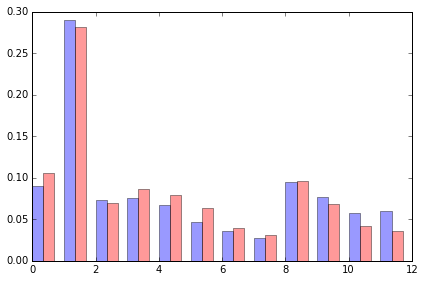

In [54]:
n_groups = 12

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, np.array(farms), bar_width,
                 alpha=opacity,
                 color='b',
                 label='Model')

rects2 = plt.bar(index + bar_width, np.array(farm_pdf_data), bar_width,
                 alpha=opacity,
                 color='r',
                 label='Data')

plt.tight_layout()
plt.show()

That is a pretty close fit. What about the other stuff?

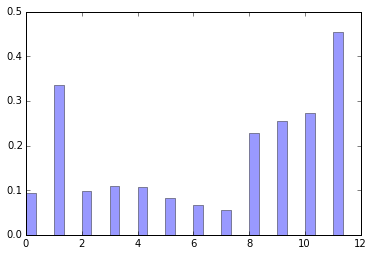

In [55]:
fig, ax = plt.subplots()
rects1 = plt.bar(index, np.array(Capital), bar_width,
                 alpha=opacity,
                 color='b',
                 label='Model')
plt.show()